Access: Download, collect, or scrape* the dataset from relevant source(s). In other words, can you get the data on your local machine or in a cloud based repository?

Load: Start a new Jupyter Notebook, import necessary Python libraries (e.g., pandas, numpy, sklearn), and load your dataset. 

Understand: Examine the dataset. Ensure you understand what different columns/rows represent or the image/text intricacies. Report the total size of your data in megabytes or gigabytes.  

Preprocess: Propose or perform basic dataset cleaning to make it suitable for analysis, visualization, and modeling which you will pursue in later milestones. Document each step in your Jupyter Notebook to justify the preprocessing decisions made. Reference the next section for details on what comprehensive data cleaning and preprocessing should include. 

- Missing Data, Data Imbalance, Feature Scaling

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ast 

In [15]:
df2 = pd.read_csv("archive/jigsaw-toxic-comment-train.csv")

In [16]:
print(df2.shape)
print(df2.columns)
print(df2.dtypes)
df2.head()

(223549, 8)
Index(['id', 'comment_text', 'toxic', 'severe_toxic', 'obscene', 'threat',
       'insult', 'identity_hate'],
      dtype='object')
id               object
comment_text     object
toxic             int64
severe_toxic      int64
obscene           int64
threat            int64
insult            int64
identity_hate     int64
dtype: object


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [12]:
df = pd.read_csv("archive/jigsaw-toxic-comment-train-processed-seqlen128.csv")

In [13]:
print(df.shape)
print(df.columns)
print(df.dtypes)
df.head()

(223549, 11)
Index(['id', 'comment_text', 'toxic', 'severe_toxic', 'obscene', 'threat',
       'insult', 'identity_hate', 'input_word_ids', 'input_mask',
       'all_segment_id'],
      dtype='object')
id                object
comment_text      object
toxic              int64
severe_toxic       int64
obscene            int64
threat             int64
insult             int64
identity_hate      int64
input_word_ids    object
input_mask        object
all_segment_id    object
dtype: object


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,input_word_ids,input_mask,all_segment_id
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,"(101, 27746, 31609, 11809, 24781, 10105, 70971...","(1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,"(101, 141, 112, 56237, 10874, 106, 10357, 1825...","(1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,"(101, 35936, 10817, 117, 146, 112, 181, 30181,...","(1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,"(101, 107, 15946, 146, 10944, 112, 188, 13086,...","(1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,"(101, 11065, 117, 52523, 117, 10301, 15127, 51...","(1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [ ]:
# missingness
df.isnull().sum().sort_values(ascending=False)


id                0
comment_text      0
toxic             0
severe_toxic      0
obscene           0
threat            0
insult            0
identity_hate     0
input_word_ids    0
input_mask        0
all_segment_id    0
dtype: int64

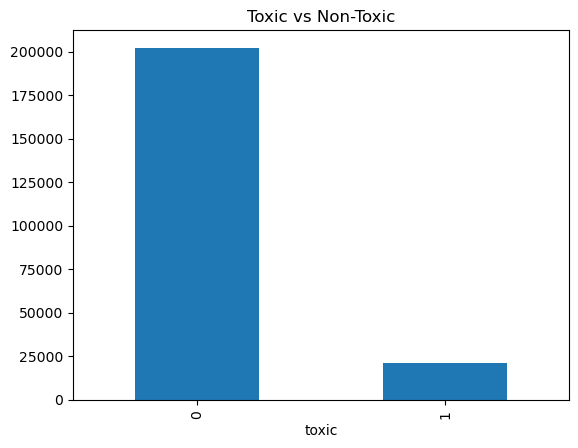

In [ ]:
# data imbalance
df['toxic'].value_counts().plot(kind='bar', title='Toxic vs Non-Toxic')
plt.show()

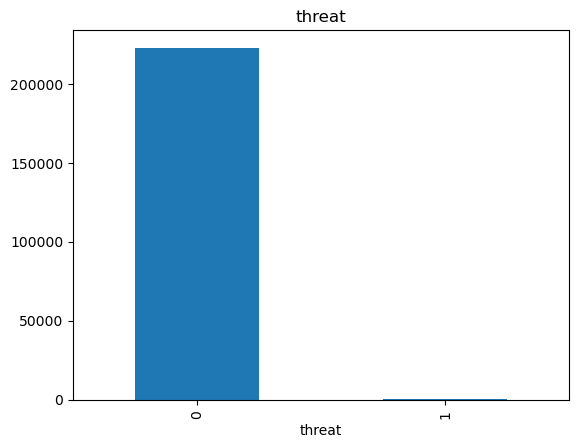

In [27]:
df['threat'].value_counts().plot(kind='bar', title='threat')
plt.show()

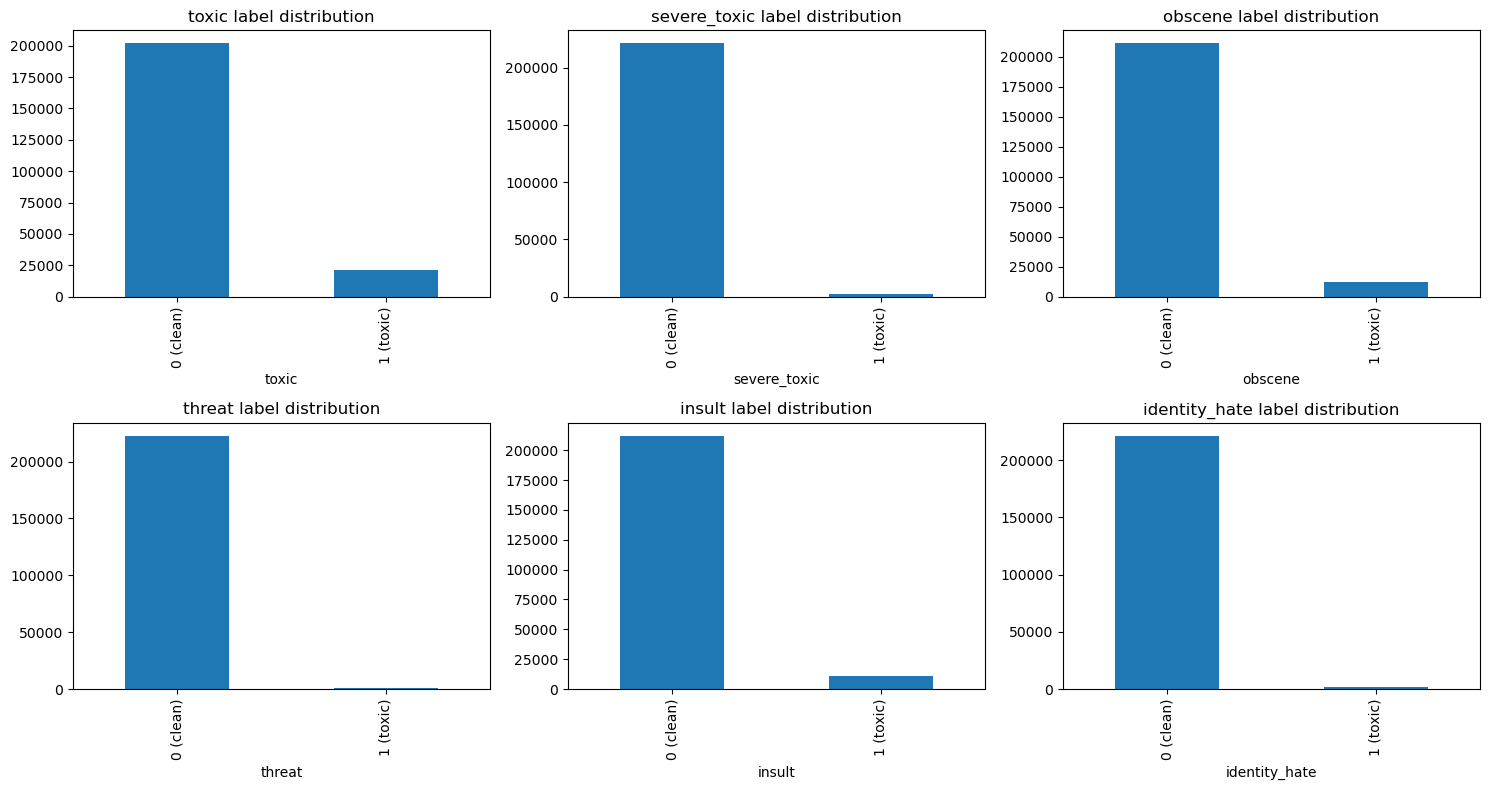

In [26]:
label_cols = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.flatten()

for i, col in enumerate(label_cols):
    df[col].value_counts().sort_index().plot(kind='bar', ax=axes[i])
    axes[i].set_title(f'{col} label distribution')
    axes[i].set_xticks([0, 1])
    axes[i].set_xticklabels(['0 (clean)', '1 (toxic)'])

plt.tight_layout()
plt.show()

In [25]:
# preprocessing

# Convert input-related columns from string to list of ints
for col in ['input_word_ids', 'input_mask', 'all_segment_id']:
    df[col] = df[col].apply(ast.literal_eval)